# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

### Описание данных

Признаки
* RowNumber — индекс строки в данных
* CustomerId — уникальный идентификатор клиента
* Surname — фамилия
* CreditScore — кредитный рейтинг
* Geography — страна проживания
* Gender — пол
* Age — возраст
* Tenure — сколько лет человек является клиентом банка
* Balance — баланс на счёте
* NumOfProducts — количество продуктов банка, используемых клиентом
* HasCrCard — наличие кредитной карты
* IsActiveMember — активность клиента
* EstimatedSalary — предполагаемая зарплата

Целевой признак
* Exited — факт ухода клиента

## Подготовка данных

### Импорт библиотек

In [1]:
!pip install sweetviz -q
!pip install pandas_profiling==1.4.1 -q
!pip install pandas==0.25.3 -q
!pip install -U scikit-learn -q

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas_profiling
from pandas_profiling import ProfileReport

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
#from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
#from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score


%matplotlib inline

In [3]:
# Загрузка датасета

try:
    df = pd.read_csv('/datasets/Churn.csv')
except:
    df = pd.read_csv('F:/Churn.csv')
    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
pandas_profiling.ProfileReport(df)

/home/jovyan/.local/lib/python3.7/site-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,14
Number of observations,10000
Total Missing (%),0.6%
Total size in memory,1.1 MiB
Average record size in memory,112.0 B
Numeric,8
Categorical,3
Boolean,3
Date,0
Text (Unique),0
Rejected,0


Есть пропуски в колонке Tenure

In [5]:
print('Доля пропусков в Tenure составляет', df.Tenure.isna().mean())

Доля пропусков в Tenure составляет 0.0909


In [7]:
print('Количество пропусков в Tenure составляет', df.Tenure.isna().sum())

Количество пропусков в Tenure составляет 909


In [8]:
df.query('Tenure.isna()').head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0


In [9]:
df.Tenure.value_counts().to_frame()

,Tenure
1.0,952
2.0,950
8.0,933
3.0,928
5.0,927
7.0,925
4.0,885
9.0,882
6.0,881
10.0,446


Так как Tenure заполнен значениями примерно одинаково за исключненим 0 и 10, проведем замену пропусков случайными значенями в диапазоне от 0 до 10. Это позволит нем сохраить объем выборки в отличии от удаления строк с пропусками

In [10]:
df = df.apply(lambda x: x.fillna(np.random.randint(0, 10)), axis=1)

In [11]:
df.Tenure.isna().sum()

0

In [12]:
df.Tenure.value_counts().to_frame()

,Tenure
2.0,1049
1.0,1040
3.0,1025
7.0,1024
5.0,1022
8.0,1016
9.0,981
4.0,963
6.0,962
0.0,472


Названия колонок переименуем согласно правилу

In [13]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [14]:
df.set_axis(['row_number',
             'customer_id', 
             'surname', 
             'credit_score', 
             'geography', 
             'gender', 
             'age', 
             'tenure', 
             'balance', 
             'products_num', 
             'has_cr_card', 
             'is_active', 
             'salary', 
             'exited'], axis=1, inplace=True)

In [15]:
df.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'products_num', 'has_cr_card',
       'is_active', 'salary', 'exited'],
      dtype='object')

Проведем преобразование данных согласно поставленной задачи обучения модели предсказания целевого признака exited: 
* уберем из выборки колонки row_number, customer_id, surname, 
* колонки с категориальными данными преобразуем в числовые по принципу OHE
* колонки с числовыми вещественными данными подвергнем стандартизации

In [16]:
data = df.drop(['row_number', 'customer_id', 'surname'], axis=1)

Колонки с категориальными данными преобразуем в числовые по принципу OHE (one hot encoding)

In [17]:
data_ohe = pd.get_dummies(data, drop_first=True)

Разделим данные на фичи и таргет для обучения модели

In [18]:
target = data_ohe['exited']
features = data_ohe.drop('exited', axis=1)

Разобъем фичи и таргет на обучающую, валидационную и тестовую выборки в соотношении 60/20/20

In [19]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=12345) 

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345) 

In [20]:
# Убедимся в правильности разделения датасета

print('Размер всего датасета:', data_ohe.shape, '{:.0%}'.format(len(data_ohe)/len(data_ohe)))
print('Размер фичей обучающей выборки:', features_train.shape, '{:.0%}'.format(len(features_train)/len(data_ohe)))
print('Размер фичей валидационной выборки:', features_valid.shape, '{:.0%}'.format(len(features_valid)/len(data_ohe)))
print('Размер фичей тестовой выборки:', features_test.shape, '{:.0%}'.format(len(features_test)/len(data_ohe)))
print('Размер целевого признака обучающей выборки:', target_train.shape, '{:.0%}'.format(len(target_train)/len(data_ohe)))
print('Размер целевого признака валидационной выборки:', target_valid.shape, '{:.0%}'.format(len(target_valid)/len(data_ohe)))
print('Размер целевого признака тестовой выборки:', target_test.shape, '{:.0%}'.format(len(target_test)/len(data_ohe)))

Размер всего датасета: (10000, 12) 100%
Размер фичей обучающей выборки: (6000, 11) 60%
Размер фичей валидационной выборки: (2000, 11) 20%
Размер фичей тестовой выборки: (2000, 11) 20%
Размер целевого признака обучающей выборки: (6000,) 60%
Размер целевого признака валидационной выборки: (2000,) 20%
Размер целевого признака тестовой выборки: (2000,) 20%


Стандартизируем числовые вещественные данные

In [21]:
numeric = ['credit_score', 'age', 'tenure', 'balance', 'products_num', 'salary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric]) 
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric]) 

In [22]:
features_train.head()

,credit_score,age,tenure,balance,products_num,has_cr_card,is_active,salary,geography_Germany,geography_Spain,gender_Male
7479,-0.886751,-0.373192,1.044851,1.232271,-0.891560,1,0,-0.187705,0,1,1
3411,0.608663,-0.183385,1.044851,0.600563,-0.891560,0,0,-0.333945,0,0,0
6027,2.052152,0.480939,-0.686659,1.027098,0.830152,0,1,1.503095,1,0,1
1247,-1.457915,-1.417129,0.352247,-1.233163,0.830152,1,0,-1.071061,0,0,1
3716,0.130961,-1.132419,-1.032961,1.140475,-0.891560,0,0,1.524268,1,0,0


In [23]:
features_test.head()

,credit_score,age,tenure,balance,products_num,has_cr_card,is_active,salary,geography_Germany,geography_Spain,gender_Male
7041,-2.226392,-0.088482,-1.032961,-1.233163,0.830152,1,0,0.647083,0,0,1
5709,-0.087120,0.006422,1.391153,-1.233163,-0.891560,1,0,-1.658410,0,0,0
7117,-0.917905,-0.752805,0.005945,0.722307,-0.891560,1,1,-1.369334,0,1,1
7775,-0.253277,0.101325,1.737455,-1.233163,0.830152,1,0,0.075086,0,1,1
8735,0.785204,-0.847708,1.737455,0.615625,-0.891560,0,1,-1.070919,0,0,1


### Выводы

* Данные соответствуют заявленным описаниям и типам. 
*В колонке Tenure есть пропуски, их доля составила 9%, заполнили случайными значениями в диапазоне от 0 до 10.
*Провели замену названий колонок.
*Проведем преобразование данных согласно поставленной задачи обучения модели предсказания целевого признака exited:
*убрали из выборки колонки row_number, customer_id, surname,
*колонки с категориальными данными преобразовали в числовые по принципу OHE
*колонки с числовыми вещественными данными подвергли стандартизации

## Исследование задачи

Исследование баланса классов

In [24]:
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print(confusion_matrix(target_valid, predicted_valid))

[[1372  210]
 [ 214  204]]


Видим, что баланс классов нарушен

In [25]:
target[target == 0].count() / target[target == 1].count()

3.9091801669121256

Дисбаланс классов в целевом признаке кратен примерно 4

In [26]:
# Полнота прогноза

recall_score(target_valid, predicted_valid)

0.4880382775119617

In [27]:
# Точность прогноза

precision_score(target_valid, predicted_valid)

0.4927536231884058

In [28]:
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.49038461538461536


Метрика F1 на несбалансированной модели при алгоритме решающего дерева показывает значение ниже порогового 0.59

In [29]:
for depth in range(2, 31, 1):    
    model = RandomForestClassifier(random_state=12345, n_estimators=50, max_depth=depth)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)

    print('Глубина:', depth, 'F1:', f1_score(target_valid, predicted_valid))

Глубина: 2 F1: 0.1853448275862069
Глубина: 3 F1: 0.26639344262295084
Глубина: 4 F1: 0.40293040293040294
Глубина: 5 F1: 0.46735395189003437
Глубина: 6 F1: 0.5256198347107438
Глубина: 7 F1: 0.5527156549520766
Глубина: 8 F1: 0.5614035087719298
Глубина: 9 F1: 0.5758998435054773
Глубина: 10 F1: 0.5632911392405064
Глубина: 11 F1: 0.5736434108527132
Глубина: 12 F1: 0.5801526717557252
Глубина: 13 F1: 0.5727136431784108
Глубина: 14 F1: 0.5727272727272728
Глубина: 15 F1: 0.5739910313901345
Глубина: 16 F1: 0.5701492537313433
Глубина: 17 F1: 0.5824665676077266
Глубина: 18 F1: 0.5654135338345865
Глубина: 19 F1: 0.5825825825825826
Глубина: 20 F1: 0.5701357466063349
Глубина: 21 F1: 0.56752655538695
Глубина: 22 F1: 0.5727272727272728
Глубина: 23 F1: 0.56797583081571
Глубина: 24 F1: 0.5636363636363636
Глубина: 25 F1: 0.5636363636363636
Глубина: 26 F1: 0.5636363636363636
Глубина: 27 F1: 0.5636363636363636
Глубина: 28 F1: 0.5636363636363636
Глубина: 29 F1: 0.5636363636363636
Глубина: 30 F1: 0.56363636363

In [30]:
for depth in range(2, 31, 1):    
    model = RandomForestClassifier(random_state=12345, n_estimators=60, max_depth=depth)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)

    print('Глубина:', depth, 'F1:', f1_score(target_valid, predicted_valid))

Глубина: 2 F1: 0.15418502202643172
Глубина: 3 F1: 0.24481327800829872
Глубина: 4 F1: 0.40293040293040294
Глубина: 5 F1: 0.47440273037542663
Глубина: 6 F1: 0.5320197044334976
Глубина: 7 F1: 0.5576923076923077
Глубина: 8 F1: 0.5614035087719298
Глубина: 9 F1: 0.5727699530516431
Глубина: 10 F1: 0.5615141955835962
Глубина: 11 F1: 0.5679012345679013
Глубина: 12 F1: 0.5749235474006116
Глубина: 13 F1: 0.572289156626506
Глубина: 14 F1: 0.5769805680119582
Глубина: 15 F1: 0.5765765765765767
Глубина: 16 F1: 0.5663189269746647
Глубина: 17 F1: 0.5878877400295421
Глубина: 18 F1: 0.5667655786350148
Глубина: 19 F1: 0.588410104011887
Глубина: 20 F1: 0.571001494768311
Глубина: 21 F1: 0.5748865355521936
Глубина: 22 F1: 0.5787878787878789
Глубина: 23 F1: 0.5731523378582202
Глубина: 24 F1: 0.56752655538695
Глубина: 25 F1: 0.563165905631659
Глубина: 26 F1: 0.563165905631659
Глубина: 27 F1: 0.563165905631659
Глубина: 28 F1: 0.563165905631659
Глубина: 29 F1: 0.563165905631659
Глубина: 30 F1: 0.563165905631659


In [31]:
for depth in range(2, 31, 1):    
    model = RandomForestClassifier(random_state=12345, n_estimators=70, max_depth=depth)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)

    print('Глубина:', depth, 'F1:', f1_score(target_valid, predicted_valid))

Глубина: 2 F1: 0.11286681715575622
Глубина: 3 F1: 0.23799582463465552
Глубина: 4 F1: 0.38589981447124305
Глубина: 5 F1: 0.48287671232876717
Глубина: 6 F1: 0.533112582781457
Глубина: 7 F1: 0.5568
Глубина: 8 F1: 0.5599999999999999
Глубина: 9 F1: 0.5678627145085803
Глубина: 10 F1: 0.5629860031104199
Глубина: 11 F1: 0.5793528505392913
Глубина: 12 F1: 0.5891238670694864
Глубина: 13 F1: 0.5817091454272864
Глубина: 14 F1: 0.5709969788519637
Глубина: 15 F1: 0.5739910313901345
Глубина: 16 F1: 0.572289156626506
Глубина: 17 F1: 0.5838323353293413
Глубина: 18 F1: 0.5752212389380531
Глубина: 19 F1: 0.5919282511210762
Глубина: 20 F1: 0.5701357466063349
Глубина: 21 F1: 0.5787106446776611
Глубина: 22 F1: 0.5791855203619909
Глубина: 23 F1: 0.5735735735735735
Глубина: 24 F1: 0.5714285714285714
Глубина: 25 F1: 0.5714285714285714
Глубина: 26 F1: 0.5714285714285714
Глубина: 27 F1: 0.5714285714285714
Глубина: 28 F1: 0.5714285714285714
Глубина: 29 F1: 0.5714285714285714
Глубина: 30 F1: 0.5714285714285714


In [32]:
for depth in range(2, 31, 1):    
    model = RandomForestClassifier(random_state=12345, n_estimators=100, max_depth=depth)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)

    print('Глубина:', depth, 'F1:', f1_score(target_valid, predicted_valid))

Глубина: 2 F1: 0.1294642857142857
Глубина: 3 F1: 0.23749999999999996
Глубина: 4 F1: 0.37757009345794396
Глубина: 5 F1: 0.4626086956521739
Глубина: 6 F1: 0.5337726523887973
Глубина: 7 F1: 0.5530546623794212
Глубина: 8 F1: 0.5614035087719298
Глубина: 9 F1: 0.577639751552795
Глубина: 10 F1: 0.5714285714285714
Глубина: 11 F1: 0.5780525502318393
Глубина: 12 F1: 0.5862595419847327
Глубина: 13 F1: 0.5753424657534246
Глубина: 14 F1: 0.5778443113772455
Глубина: 15 F1: 0.5774436090225564
Глубина: 16 F1: 0.5688622754491017
Глубина: 17 F1: 0.5896296296296296
Глубина: 18 F1: 0.5654761904761905
Глубина: 19 F1: 0.588410104011887
Глубина: 20 F1: 0.5804511278195489
Глубина: 21 F1: 0.5774436090225564
Глубина: 22 F1: 0.5735963581183612
Глубина: 23 F1: 0.5770392749244713
Глубина: 24 F1: 0.575712143928036
Глубина: 25 F1: 0.5709969788519637
Глубина: 26 F1: 0.56797583081571
Глубина: 27 F1: 0.56797583081571
Глубина: 28 F1: 0.56797583081571
Глубина: 29 F1: 0.56797583081571
Глубина: 30 F1: 0.56797583081571


Для несбалансированной модели на алгоритме случайного леса метрика F1 максимальна при глубине равной 16 и количестве деревьев 60 и составляет 0.6014, что незначительно выше 0.59

In [33]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print('F1:', f1_score(target_valid, predicted_valid))

F1: 0.33220338983050846


Метрика F1 для несбалансированной модели на алгоритме логистической регрессии 0.30, что значительно ниже порогового 0.59 и является наихудшим результатом

### Выводы

* Изучены модели без учёта дисбаланса
* Худший результат относительно метрики F1 показала модель на логистической регрессии, а лучший - на алгоритме случайного леса

In [34]:
model = RandomForestClassifier(random_state=12345, n_estimators=60, max_depth=16)
model.fit(features_train, target_train)
probabilities_valid_u = model.predict_proba(features_valid)
probabilities_one_valid_u = probabilities_valid_u[:, 1]

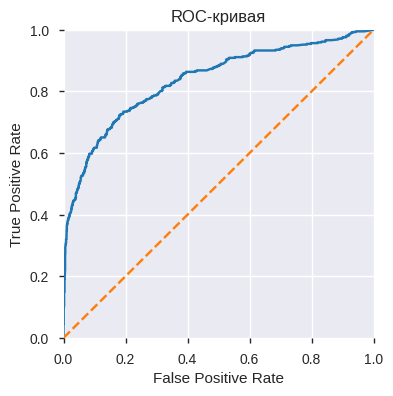

In [35]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_u) 

plt.figure(figsize=(4, 4))

plt.plot(fpr, tpr)

# ROC-кривая случайной модели 
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.title("ROC-кривая")

plt.show()

In [36]:
roc_auc_score(target_valid, probabilities_one_valid_u)

0.8359149583532444

<div class="alert alert-block alert-success">
<b>Успех[2]:</b> Есть 
</div>


## Борьба с дисбалансом

Применим метод upsampling для устранения дисбаланса классов в выборках

In [37]:
def upsample(features, target, repeat):
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled


features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

Теперь применим метод downsampling для устранения дисбаланса классов в выборках

In [38]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled


features_downsampled, target_downsampled = downsample(features_train, target_train, 0.39)

In [39]:
target[target == 0].count() / target[target == 1].count()

3.9091801669121256

Дисбаланс классов в целевом признаке кратен примерно 4

Логистическая регрессия с upsampling

In [40]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.4875536480686695


Логистическая регрессия с downsampling

In [41]:
model = LogisticRegression(random_state=12345, solver='liblinear').fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.4989293361884368


Логистическая регрессия с гиперпараметром class_weight='balanced'

In [42]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print('F1:', f1_score(target_valid, predicted_valid))

F1: 0.488013698630137


Метрика F1 для сбалансированной модели на алгоритме логистической регрессии достигает максимума 0.50 при применении гиперпараметра взвешенных классов, что ниже порогового 0.59

Случайный лес с upsampling

In [43]:
model = RandomForestClassifier(random_state=12345, n_estimators=60, max_depth=16).fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5959079283887468


Случайный лес с downsampling

In [44]:
model = RandomForestClassifier(random_state=12345, n_estimators=60, max_depth=16).fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.6064659977703456


Случайный лес с гиперпараметром class_weight='balanced'

In [45]:
model = RandomForestClassifier(random_state=12345, n_estimators=60, max_depth=16, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print('F1:', f1_score(target_valid, predicted_valid))

F1: 0.5825825825825826


Метрика F1 для сбалансированной модели на алгоритме случайного леса достигает максимума 0.60 при применении downsampling, что выше порогового 0.59

Дерево решений с upsampling

In [46]:
model = DecisionTreeClassifier(random_state=12345).fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.49264705882352944


Дерево решений с downsampling

In [47]:
model = DecisionTreeClassifier(random_state=12345).fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5014031805425632


Дерево решений с гиперпараметром class_weight='balanced'

In [48]:
model = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print('F1:', f1_score(target_valid, predicted_valid))

F1: 0.4777227722772277


Метрика F1 для сбалансированной модели на алгоритме дерева решений достигает максимума 0.49 при применении взвешенных классов, что ниже порогового 0.59

### Выводы

* Изучены модели без учёта дисбаланса
* Худший результат относительно метрики F1 показала модель на логистической регрессии, а лучший - на алгоритме случайного леса при устранении дисбаланса классов методом upsampling, при этом мы вписываемся в порог 0.59.

In [49]:
model = RandomForestClassifier(random_state=12345, n_estimators=60, max_depth=16).fit(features_downsampled, target_downsampled)
probabilities_valid_b = model.predict_proba(features_valid)
probabilities_one_valid_b = probabilities_valid_b[:, 1]

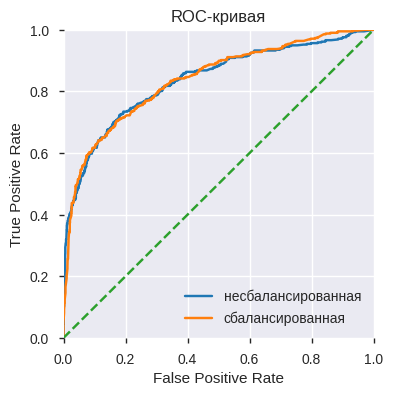

In [50]:
plt.figure(figsize=(4, 4))

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_u) 
plt.plot(fpr, tpr)
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_b) 
plt.plot(fpr, tpr)

# ROC-кривая случайной модели 
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(['несбалансированная', 'сбалансированная'], loc='best')
plt.title("ROC-кривая")

plt.show()

In [51]:
roc_auc_score(target_valid, probabilities_one_valid_b)

0.838488014081866

<div class="alert alert-block alert-success">
<b>Успех[2]:</b> Есть 
</div>


## Тестирование модели

Итак, исследование моделей показало, что лучший результат метрики F1 достигается на сбалансированной методом downsampling модели на алгоритме случайного леса при глубине равной 17 и количестве деревьев 100

In [52]:
model = RandomForestClassifier(
    random_state=12345, 
    n_estimators=100, 
    max_depth=25).fit(features_upsampled, target_upsampled)

predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.6050198150594451


Проверим этот результат на тестовой выборке

In [53]:
predicted_test = model.predict(features_test)

print("F1:", f1_score(target_test, predicted_test))

F1: 0.583883751651255


Измерим AUC-ROC и сравним её значение с F1-мерой на валидационной и тестовой выборках

In [54]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.7, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid) 
    recall = recall_score(target_valid, predicted_valid) 
    f1 = f1_score(target_valid, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1-мера = {:.3f}".format(
        threshold, precision, recall, f1))

Порог = 0.00 | Точность = 0.217, Полнота = 0.993, F1-мера = 0.357
Порог = 0.02 | Точность = 0.237, Полнота = 0.983, F1-мера = 0.382
Порог = 0.04 | Точность = 0.254, Полнота = 0.959, F1-мера = 0.402
Порог = 0.06 | Точность = 0.271, Полнота = 0.945, F1-мера = 0.422
Порог = 0.08 | Точность = 0.287, Полнота = 0.923, F1-мера = 0.438
Порог = 0.10 | Точность = 0.304, Полнота = 0.914, F1-мера = 0.457
Порог = 0.12 | Точность = 0.326, Полнота = 0.902, F1-мера = 0.479
Порог = 0.14 | Точность = 0.343, Полнота = 0.873, F1-мера = 0.492
Порог = 0.16 | Точность = 0.361, Полнота = 0.844, F1-мера = 0.506
Порог = 0.18 | Точность = 0.374, Полнота = 0.823, F1-мера = 0.514
Порог = 0.20 | Точность = 0.391, Полнота = 0.809, F1-мера = 0.527
Порог = 0.22 | Точность = 0.415, Полнота = 0.789, F1-мера = 0.544
Порог = 0.24 | Точность = 0.436, Полнота = 0.770, F1-мера = 0.557
Порог = 0.26 | Точность = 0.456, Полнота = 0.761, F1-мера = 0.570
Порог = 0.28 | Точность = 0.478, Полнота = 0.749, F1-мера = 0.583
Порог = 0.

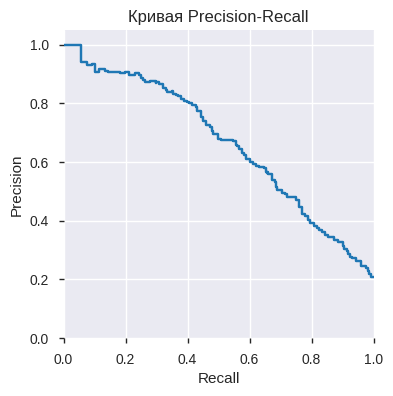

In [55]:
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_one_valid)

plt.figure(figsize=(4, 4))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show() 

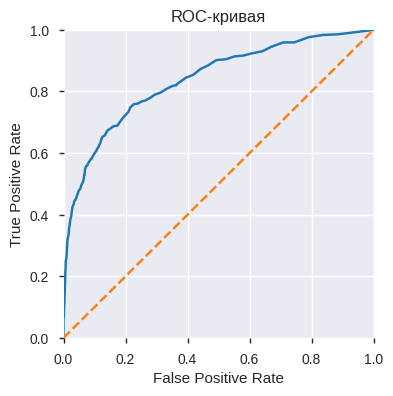

In [56]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 

plt.figure(figsize=(4, 4))

plt.plot(fpr, tpr)

# ROC-кривая случайной модели 
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.title("ROC-кривая")

plt.show()

In [57]:
roc_auc_score(target_valid, probabilities_one_valid)

0.8371549852104114

In [58]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

for threshold in np.arange(0, 0.7, 0.02):
    predicted_test = probabilities_one_test > threshold
    precision = precision_score(target_test, predicted_test)
    recall = recall_score(target_test, predicted_test)
    f1 = f1_score(target_test, predicted_test)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1-мера = {:.3f}".format(
        threshold, precision, recall, f1))

Порог = 0.00 | Точность = 0.221, Полнота = 0.993, F1-мера = 0.361
Порог = 0.02 | Точность = 0.242, Полнота = 0.988, F1-мера = 0.389
Порог = 0.04 | Точность = 0.264, Полнота = 0.986, F1-мера = 0.416
Порог = 0.06 | Точность = 0.284, Полнота = 0.967, F1-мера = 0.440
Порог = 0.08 | Точность = 0.304, Полнота = 0.946, F1-мера = 0.460
Порог = 0.10 | Точность = 0.324, Полнота = 0.931, F1-мера = 0.481
Порог = 0.12 | Точность = 0.340, Полнота = 0.913, F1-мера = 0.496
Порог = 0.14 | Точность = 0.359, Полнота = 0.889, F1-мера = 0.512
Порог = 0.16 | Точность = 0.378, Полнота = 0.872, F1-мера = 0.527
Порог = 0.18 | Точность = 0.392, Полнота = 0.844, F1-мера = 0.536
Порог = 0.20 | Точность = 0.418, Полнота = 0.827, F1-мера = 0.555
Порог = 0.22 | Точность = 0.440, Полнота = 0.809, F1-мера = 0.570
Порог = 0.24 | Точность = 0.452, Полнота = 0.780, F1-мера = 0.572
Порог = 0.26 | Точность = 0.466, Полнота = 0.749, F1-мера = 0.575
Порог = 0.28 | Точность = 0.487, Полнота = 0.738, F1-мера = 0.586
Порог = 0.

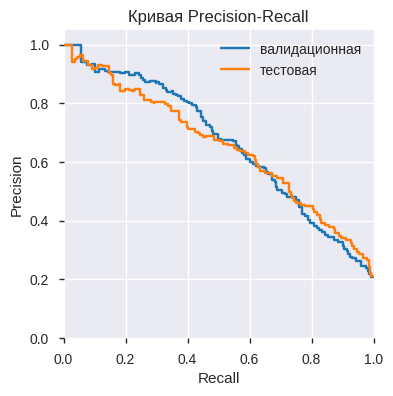

In [59]:
plt.figure(figsize=(4, 4))

precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_one_valid)
plt.step(recall, precision, where='post')

precision, recall, thresholds = precision_recall_curve(target_test, probabilities_one_test)
plt.step(recall, precision, where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.legend(['валидационная', 'тестовая'], loc='best')
plt.show() 

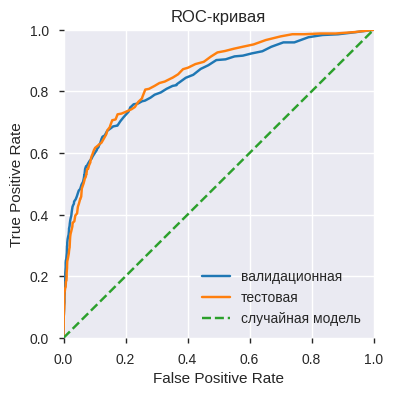

In [60]:
plt.figure(figsize=(4, 4))

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 
plt.plot(fpr, tpr)
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 
plt.plot(fpr, tpr)

# ROC-кривая случайной модели 
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.title("ROC-кривая")
plt.legend(['валидационная', 'тестовая', 'случайная модель'], loc='best')

plt.show() 

In [61]:
roc_auc_score(target_test, probabilities_one_test)

0.8497970980600266

### Выводы

Итак мы имеем следующие показатели на выбранной обученной модели:
* F1-мера: 0.597 (выше 0.59), при пороге в 0.4 достигается 0.612
* ROC AUC: 0.85

Таким образом можно считать, что поставленных целей достичь удалось.

В целях понимания степени влияния фичей на целевой признак, выведем их важность.

In [62]:
import time

start_time = time.time()
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.049 seconds


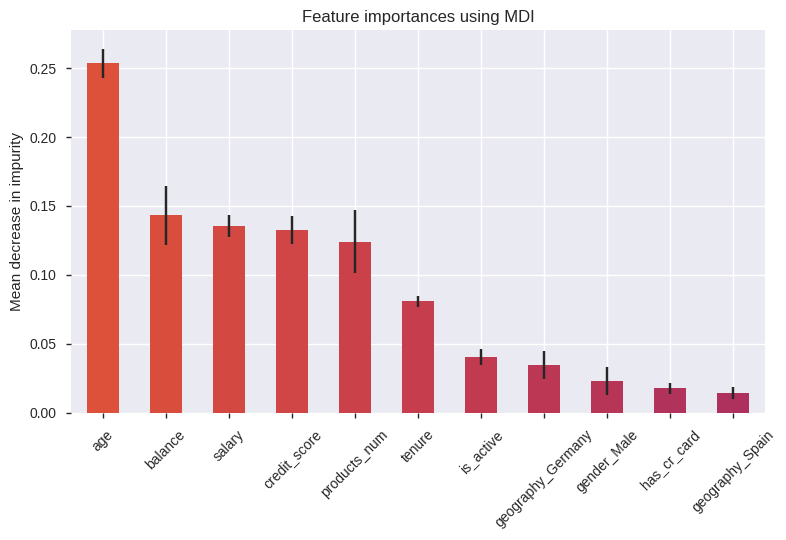

In [63]:
model_importances = pd.Series(importances, index=features.columns)

fig, ax = plt.subplots()
color = cm.inferno_r(np.linspace(.4,.8, 30))
model_importances.sort_values(ascending=False).plot.bar(yerr=std, ax=ax, stacked=True,  color=color, rot=45)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
#plt.show()

Видим, что основными факторами влияния на целевой признак прогнозирования, уйдёт клиент из банка в ближайшее время или нет, являются возраст клиента, доход, объем средств на счету, число банковских продуктов и кредитная история.